In [1]:
import os 

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome')
    train_path = '/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/train.csv'
    test_path = '/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/test.csv'
    IN_COLAB = True
except:
    os.chdir(r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\Connectome Projekt\Connectome')
    train_path = r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\data\delcode\train.csv'
    test_path = r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\data\delcode\test.csv'
    IN_COLAB = False

!pip install .

Mounted at /content/drive
Processing /content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for src: filename=src-0.1.0-py3-none-any.whl size=31970 sha256=ebb1667b44e1f26659d19841acb01def290f396deb2ee4635b5d98908921bb90
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ej_113l/wheels/33/78/f1/218471f49448b8e9df2af6ab9b92633a6fe2826c87471eba83
Successfully built src


### Importing Libraries

In [2]:
!pip install bayesian-optimization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 
from bayes_opt import BayesianOptimization
from typing import Union

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import scipy.stats
import src.preprocessing.data_loader as dtl
from src.models.lgbm_bo import *
from math import sqrt
from datetime import date

plt.style.use("ggplot")
%matplotlib inline

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=c44b02c9c39f2102534cd287731b733a3daf40617ab3d48887223d35451af0d5
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


### Loading and Transforming Data

In [3]:
%%time
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

CPU times: user 18.3 s, sys: 772 ms, total: 19.1 s
Wall time: 22 s


In [4]:
y, X = dtl.preprocess_data(train)
X = X.drop(columns = ['MEM_score', 'Apoe'], inplace = False)
y_test, X_test = dtl.preprocess_data(test)
X_test = X_test.drop(columns = ['MEM_score', 'Apoe'], inplace = False)
del train, test

### Baseline Model (XGB Untuned Classifier)

In [26]:
%%time
lgb_baseline = lgb.LGBMClassifier()
lgb_baseline.fit(X,y)

CPU times: user 3min 19s, sys: 171 ms, total: 3min 19s
Wall time: 55.9 s


In [27]:
lgb_baseline

LGBMClassifier()

Text(0, 0.5, 'Feature Importance Score')

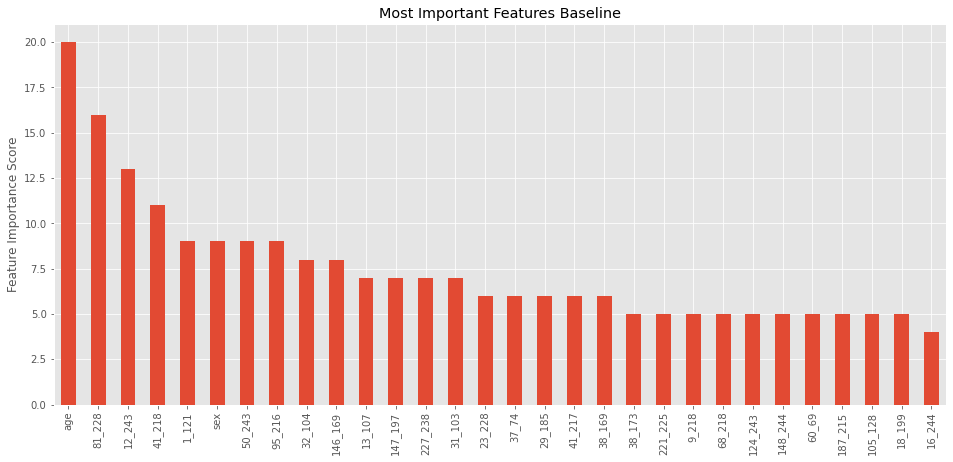

In [7]:
features = list(X.columns)
feat_imp = pd.Series(lgb_baseline.feature_importances_, features).sort_values(ascending=False)
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(7)
feat_imp[0:30].plot(kind='bar', title='Most Important Features Baseline')
plt.ylabel('Feature Importance Score')


In [29]:
print('Accuracy of the GBM on test set: {:.3f}'.format(lgb_baseline.score(X_test, y_test)), "\n")
pred_base = lgb_baseline.predict(X_test)
print("Classification Report - Baseline [Test]")
print(classification_report(y_test, pred_base))
fpr, tpr, thresholds = roc_curve(y_test, pred_base, pos_label=1)
auc(fpr, tpr)

Accuracy of the GBM on test set: 0.765 

Classification Report - Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.77      0.65      0.71        37
         1.0       0.76      0.85      0.80        48

    accuracy                           0.76        85
   macro avg       0.77      0.75      0.75        85
weighted avg       0.77      0.76      0.76        85



0.7514076576576576

### BO

In [ ]:
USE_GPU = False
if IN_COLAB and USE_GPU:
    #for gpu use: https://www.thekerneltrip.com/machine-learning/lgbmgpu/
    !pip install lightgbm --install-option=--gpu

In [18]:
lgb_tuned = hpo_lgbm(X, y, 
               n_folds=5, 
               init_points=25, 
               n_iter=200, 
               return_model=True,
               gpu=True if IN_COLAB and USE_GPU else False,
               save_model=True, 
               name="gb_classification_brainnetome",
               save_dir='/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome')

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | min_sp... | num_it... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.770897 + 0.0569136
[100]	cv_agg's auc: 0.782274 + 0.0528738
[150]	cv_agg's auc: 0.78788 + 0.0507531
[200]	cv_agg's auc: 0.788968 + 0.0500039
[250]	cv_agg's auc: 0.788968 + 0.0500039
|  1        |  0.7899   |  0.9036   |  0.08366  |  33.74    |  0.0126   |  0.01166  |  1.5e+03  |  57.68    |  0.4246   |
[50]	cv_agg's auc: 0.761325 + 0.0532174
[100]	cv_agg's auc: 0.779867 + 0.0495077
[150]	cv_agg's auc: 0.779867 + 0.0495077
|  2        |  0.7818   |  0.4019   |  0.156    |  20.33    |  0.2208   |  0.05229  |  1.46e+03 |  68.08    |  0.9903   |
[50]	cv_agg's auc: 0.786924 + 0.0473909
[100]	cv_agg's auc: 0.793027 + 0.0511327
[150]	cv_agg's auc: 0.805165 + 0.0498823
[200]	cv_agg's auc: 0.808018 + 0.051862
[250]	cv_agg's auc: 0.808837 + 0.0521606
|  3        |  0.8102   |  0.8379   |  0.1039   |  35.67    |  0.2471   |  0.006393 |  1.805e+0 |  82.2     |  0.739    |
[50]	cv_agg's auc: 0.797627 + 0.0355662
[100]	cv_agg's auc: 0.812264 + 0.0393509
[150]	cv_agg's auc: 0.816

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.794903 + 0.0286153
[100]	cv_agg's auc: 0.805027 + 0.0378473
[150]	cv_agg's auc: 0.805027 + 0.0378473
|  11       |  0.8056   |  0.6263   |  0.153    |  35.19    |  0.000619 |  0.09607  |  1.711e+0 |  19.19    |  0.4858   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.776447 + 0.0564344
[100]	cv_agg's auc: 0.787922 + 0.0600536
[150]	cv_agg's auc: 0.793866 + 0.0559278
[200]	cv_agg's auc: 0.798185 + 0.0580162
[250]	cv_agg's auc: 0.799315 + 0.0557716
[300]	cv_agg's auc: 0.800287 + 0.052476
[350]	cv_agg's auc: 0.803827 + 0.0528229
[400]	cv_agg's auc: 0.805995 + 0.0538541
[450]	cv_agg's auc: 0.807638 + 0.0532629
[500]	cv_agg's auc: 0.808875 + 0.0518599
[550]	cv_agg's auc: 0.8105 + 0.0528463
|  12       |  0.811    |  0.3449   |  0.04105  |  9.337    |  0.1885   |  0.01115  |  566.2    |  75.41    |  0.2832   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.780711 + 0.0645672
[100]	cv_agg's auc: 0.790229 + 0.0673281
[150]	cv_agg's auc: 0.790229 + 0.0673281
|  13       |  0.7908   |  0.7039   |  0.2105   |  37.98    |  0.2679   |  0.0497   |  1.719e+0 |  21.41    |  0.5799   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.807549 + 0.0361673
[100]	cv_agg's auc: 0.81548 + 0.044871
[150]	cv_agg's auc: 0.814673 + 0.043961
[200]	cv_agg's auc: 0.814673 + 0.043961
|  14       |  0.8158   |  0.211    |  0.1724   |  35.09    |  0.05103  |  0.01311  |  1.809e+0 |  79.49    |  0.315    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.776848 + 0.0484041
[100]	cv_agg's auc: 0.789694 + 0.0501938
[150]	cv_agg's auc: 0.797676 + 0.0508337
[200]	cv_agg's auc: 0.802502 + 0.051914
[250]	cv_agg's auc: 0.803843 + 0.0529127
[300]	cv_agg's auc: 0.805854 + 0.0565724
[350]	cv_agg's auc: 0.807192 + 0.0583848
[400]	cv_agg's auc: 0.810072 + 0.0563429
[450]	cv_agg's auc: 0.812808 + 0.0552906
[500]	cv_agg's auc: 0.81322 + 0.0554859
[550]	cv_agg's auc: 0.816753 + 0.0558428
[600]	cv_agg's auc: 0.817838 + 0.0555987
[650]	cv_agg's auc: 0.818644 + 0.0573291
[700]	cv_agg's auc: 0.818645 + 0.0581284
[750]	cv_agg's auc: 0.820012 + 0.0587387
[800]	cv_agg's auc: 0.821108 + 0.0579161
[850]	cv_agg's auc: 0.821539 + 0.05637
[900]	cv_agg's auc: 0.821675 + 0.0563957
|  15       |  0.8222   |  0.268    |  0.02425  |  36.05    |  0.2433   |  0.02899  |  1.812e+0 |  81.26    |  0.9139   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.782831 + 0.0434451
[100]	cv_agg's auc: 0.790529 + 0.0496265
[150]	cv_agg's auc: 0.793095 + 0.0521273
[200]	cv_agg's auc: 0.793095 + 0.0521273
|  16       |  0.7943   |  0.7921   |  0.09593  |  37.48    |  0.2401   |  0.0777   |  1.713e+0 |  26.24    |  0.8112   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.778829 + 0.0734221
[100]	cv_agg's auc: 0.798307 + 0.064086
[150]	cv_agg's auc: 0.807421 + 0.0605859
[200]	cv_agg's auc: 0.813143 + 0.061463
[250]	cv_agg's auc: 0.817904 + 0.0620025
[300]	cv_agg's auc: 0.818041 + 0.0612386
[350]	cv_agg's auc: 0.818041 + 0.0612386
|  17       |  0.8187   |  0.3651   |  0.08886  |  7.6      |  0.2299   |  0.01024  |  566.5    |  74.78    |  0.3036   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.759065 + 0.0573379
[100]	cv_agg's auc: 0.776685 + 0.0506637
[150]	cv_agg's auc: 0.78786 + 0.0510428
[200]	cv_agg's auc: 0.790592 + 0.0515111
[250]	cv_agg's auc: 0.793301 + 0.0532929
[300]	cv_agg's auc: 0.793301 + 0.0532929
|  18       |  0.7934   |  0.4778   |  0.04856  |  9.067    |  0.2964   |  0.0831   |  569.8    |  74.89    |  0.4218   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.682042 + 0.0591531
[100]	cv_agg's auc: 0.700138 + 0.0642194
[150]	cv_agg's auc: 0.707564 + 0.0653021
[200]	cv_agg's auc: 0.710838 + 0.0627367
[250]	cv_agg's auc: 0.72173 + 0.0607131
[300]	cv_agg's auc: 0.7296 + 0.0614683
[350]	cv_agg's auc: 0.73614 + 0.0595369
[400]	cv_agg's auc: 0.741506 + 0.0540015
[450]	cv_agg's auc: 0.745746 + 0.0503816
[500]	cv_agg's auc: 0.750771 + 0.0494693
[550]	cv_agg's auc: 0.751338 + 0.0474001
[600]	cv_agg's auc: 0.753639 + 0.0473611
[650]	cv_agg's auc: 0.757575 + 0.0488737
[700]	cv_agg's auc: 0.760023 + 0.0491243
[750]	cv_agg's auc: 0.760686 + 0.0499895
[800]	cv_agg's auc: 0.761508 + 0.0480808
[850]	cv_agg's auc: 0.765061 + 0.0471418
[900]	cv_agg's auc: 0.765871 + 0.0481161
[950]	cv_agg's auc: 0.76532 + 0.0474491
[1000]	cv_agg's auc: 0.766139 + 0.0471121
[1050]	cv_agg's auc: 0.767097 + 0.0463192
[1100]	cv_agg's auc: 0.769005 + 0.0460703
[1150]	cv_agg's auc: 0.771723 + 0.0471549
[1200]	cv_agg's auc: 0.771852 + 0.0478489
[1250]	cv_agg's a

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.759607 + 0.0451349
[100]	cv_agg's auc: 0.780978 + 0.0484306
[150]	cv_agg's auc: 0.788588 + 0.0518164
[200]	cv_agg's auc: 0.796744 + 0.0525204
[250]	cv_agg's auc: 0.802183 + 0.0533781
[300]	cv_agg's auc: 0.801909 + 0.0535901
[350]	cv_agg's auc: 0.801909 + 0.0535901
|  20       |  0.8022   |  0.8394   |  0.05518  |  11.33    |  0.2908   |  0.05642  |  565.8    |  74.24    |  0.08875  |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.802211 + 0.0567255
[100]	cv_agg's auc: 0.81487 + 0.0565705
[150]	cv_agg's auc: 0.814465 + 0.0558945
|  21       |  0.8155   |  0.6925   |  0.22     |  7.532    |  0.2943   |  0.002458 |  563.8    |  75.78    |  0.9179   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.735528 + 0.0432846
[100]	cv_agg's auc: 0.765049 + 0.0431605
[150]	cv_agg's auc: 0.772685 + 0.0440322
[200]	cv_agg's auc: 0.778986 + 0.042388
[250]	cv_agg's auc: 0.779195 + 0.050521
[300]	cv_agg's auc: 0.785459 + 0.0509119
[350]	cv_agg's auc: 0.78984 + 0.0485381
[400]	cv_agg's auc: 0.793525 + 0.0477079
[450]	cv_agg's auc: 0.797473 + 0.0478277
[500]	cv_agg's auc: 0.799383 + 0.0484836
[550]	cv_agg's auc: 0.800051 + 0.0502441
[600]	cv_agg's auc: 0.803326 + 0.0499658
[650]	cv_agg's auc: 0.805773 + 0.0501049
[700]	cv_agg's auc: 0.805902 + 0.0509727
[750]	cv_agg's auc: 0.805496 + 0.0503505
|  22       |  0.8063   |  0.9068   |  0.03393  |  38.76    |  0.149    |  0.01217  |  1.715e+0 |  21.75    |  0.5748   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.763014 + 0.0367456
[100]	cv_agg's auc: 0.79073 + 0.0258424
[150]	cv_agg's auc: 0.792045 + 0.0349981
[200]	cv_agg's auc: 0.795257 + 0.0405985
[250]	cv_agg's auc: 0.802721 + 0.0425098
[300]	cv_agg's auc: 0.80486 + 0.0483267
[350]	cv_agg's auc: 0.809234 + 0.0471158
[400]	cv_agg's auc: 0.810998 + 0.0477044
[450]	cv_agg's auc: 0.812901 + 0.0482241
[500]	cv_agg's auc: 0.811787 + 0.0483141
|  23       |  0.814    |  0.1521   |  0.007883 |  32.32    |  0.08891  |  0.0233   |  1.814e+0 |  82.75    |  0.3918   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.784224 + 0.0617985
[100]	cv_agg's auc: 0.789973 + 0.0621886
[150]	cv_agg's auc: 0.789973 + 0.0621886
|  24       |  0.7911   |  0.493    |  0.196    |  39.29    |  0.1724   |  0.05101  |  1.811e+0 |  79.8     |  0.07159  |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.791555 + 0.0357218
[100]	cv_agg's auc: 0.812333 + 0.042858
[150]	cv_agg's auc: 0.812856 + 0.044952
|  25       |  0.813    |  0.7999   |  0.127    |  39.8     |  0.109    |  0.03348  |  1.711e+0 |  14.86    |  0.9113   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.790523 + 0.0457487
[100]	cv_agg's auc: 0.801883 + 0.0399127
[150]	cv_agg's auc: 0.804308 + 0.0427519
[200]	cv_agg's auc: 0.80336 + 0.0427007
|  26       |  0.8073   |  0.3247   |  0.07234  |  36.44    |  0.09891  |  0.08289  |  1.809e+0 |  77.98    |  0.9315   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.751873 + 0.0355823
[100]	cv_agg's auc: 0.772961 + 0.0538348
[150]	cv_agg's auc: 0.785938 + 0.0566312
[200]	cv_agg's auc: 0.79162 + 0.059259
[250]	cv_agg's auc: 0.790946 + 0.0603298
[300]	cv_agg's auc: 0.797383 + 0.0593998
[350]	cv_agg's auc: 0.799139 + 0.059815
[400]	cv_agg's auc: 0.799416 + 0.0594371
[450]	cv_agg's auc: 0.799416 + 0.0594371
|  27       |  0.7994   |  0.2641   |  0.03224  |  35.01    |  0.09328  |  0.07588  |  1.811e+0 |  80.04    |  0.9084   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.770957 + 0.0560492
[100]	cv_agg's auc: 0.785521 + 0.0556015
[150]	cv_agg's auc: 0.790293 + 0.055521
[200]	cv_agg's auc: 0.790293 + 0.055521
|  28       |  0.7911   |  0.7931   |  0.1125   |  37.88    |  0.132    |  0.0427   |  1.812e+0 |  83.21    |  0.6694   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.769006 + 0.0462227
[100]	cv_agg's auc: 0.779258 + 0.0532316
[150]	cv_agg's auc: 0.786493 + 0.0533036
[200]	cv_agg's auc: 0.786362 + 0.0528431
[250]	cv_agg's auc: 0.786362 + 0.0528431
|  29       |  0.7875   |  0.8681   |  0.06736  |  39.6     |  0.00377  |  0.0769   |  1.712e+0 |  13.41    |  0.687    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.787963 + 0.0483332
[100]	cv_agg's auc: 0.808504 + 0.056637
[150]	cv_agg's auc: 0.812958 + 0.0559793
[200]	cv_agg's auc: 0.815149 + 0.0552999
[250]	cv_agg's auc: 0.817321 + 0.0569238
[300]	cv_agg's auc: 0.817321 + 0.0569238
|  30       |  0.8173   |  0.2799   |  0.08343  |  10.63    |  0.1445   |  0.02034  |  562.7    |  74.05    |  0.46     |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.787631 + 0.061214
[100]	cv_agg's auc: 0.793375 + 0.0600062
[150]	cv_agg's auc: 0.793375 + 0.0600062
|  31       |  0.7958   |  0.4875   |  0.1833   |  6.752    |  0.01292  |  0.09421  |  564.8    |  72.09    |  0.09544  |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.788728 + 0.0622863
[100]	cv_agg's auc: 0.800794 + 0.0576137
[150]	cv_agg's auc: 0.80862 + 0.0549562
[200]	cv_agg's auc: 0.80862 + 0.0549562
|  32       |  0.8101   |  0.4321   |  0.09988  |  6.265    |  0.03878  |  0.02937  |  562.9    |  73.86    |  0.9917   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.786203 + 0.042838
[100]	cv_agg's auc: 0.800085 + 0.0513245
[150]	cv_agg's auc: 0.800085 + 0.0513245
|  33       |  0.8024   |  0.6697   |  0.15     |  33.86    |  0.2426   |  0.06314  |  1.708e+0 |  21.14    |  0.1045   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.758264 + 0.0533074
[100]	cv_agg's auc: 0.781927 + 0.0560551
[150]	cv_agg's auc: 0.790512 + 0.0502136
[200]	cv_agg's auc: 0.790249 + 0.049713
[250]	cv_agg's auc: 0.797065 + 0.0504914
[300]	cv_agg's auc: 0.805655 + 0.0523112
[350]	cv_agg's auc: 0.806345 + 0.0511707
[400]	cv_agg's auc: 0.807856 + 0.0516099
[450]	cv_agg's auc: 0.80786 + 0.0518511
|  34       |  0.8087   |  0.5227   |  0.03328  |  6.699    |  0.1773   |  0.03983  |  567.0    |  76.17    |  0.6517   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.788656 + 0.0707085
[100]	cv_agg's auc: 0.799442 + 0.0698343
[150]	cv_agg's auc: 0.799442 + 0.0698343
|  35       |  0.8013   |  0.5494   |  0.2318   |  33.98    |  0.2904   |  0.03106  |  1.814e+0 |  80.18    |  0.6731   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.785722 + 0.0398061
[100]	cv_agg's auc: 0.792791 + 0.043146
[150]	cv_agg's auc: 0.792791 + 0.043146
|  36       |  0.7928   |  0.3487   |  0.1691   |  35.63    |  0.06764  |  0.03288  |  1.808e+0 |  78.88    |  0.3875   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.79244 + 0.0515197
[100]	cv_agg's auc: 0.793088 + 0.0528134
[150]	cv_agg's auc: 0.793088 + 0.0528134
|  37       |  0.7953   |  0.7111   |  0.1807   |  13.94    |  0.02319  |  0.08653  |  175.6    |  13.59    |  0.6737   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.798236 + 0.0611569
[100]	cv_agg's auc: 0.800593 + 0.0591268
[150]	cv_agg's auc: 0.800593 + 0.0591268
|  38       |  0.8011   |  0.9852   |  0.2055   |  36.72    |  0.01231  |  0.03446  |  1.812e+0 |  81.36    |  0.3613   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.770734 + 0.0557319
[100]	cv_agg's auc: 0.774598 + 0.0540925
[150]	cv_agg's auc: 0.774598 + 0.0540925
|  39       |  0.7746   |  0.1065   |  0.2129   |  13.06    |  0.05751  |  0.09633  |  1.016e+0 |  77.68    |  0.5785   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.77001 + 0.0687188
[100]	cv_agg's auc: 0.791365 + 0.0607201
[150]	cv_agg's auc: 0.795468 + 0.0581599
[200]	cv_agg's auc: 0.795468 + 0.0581599
|  40       |  0.796    |  0.4027   |  0.1014   |  6.687    |  0.09905  |  0.05886  |  563.7    |  75.22    |  0.253    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.74423 + 0.0571464
[100]	cv_agg's auc: 0.768286 + 0.052995
[150]	cv_agg's auc: 0.77782 + 0.0516542
[200]	cv_agg's auc: 0.779173 + 0.0519503
[250]	cv_agg's auc: 0.787783 + 0.0517945
[300]	cv_agg's auc: 0.792013 + 0.0515569
[350]	cv_agg's auc: 0.792013 + 0.0515569
|  41       |  0.792    |  0.7697   |  0.0377   |  24.51    |  0.04771  |  0.06065  |  1.107e+0 |  36.0     |  0.5776   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.800225 + 0.0422898
[100]	cv_agg's auc: 0.810553 + 0.0445173
[150]	cv_agg's auc: 0.813754 + 0.0518066
[200]	cv_agg's auc: 0.817011 + 0.0526285
[250]	cv_agg's auc: 0.815258 + 0.0521527
[300]	cv_agg's auc: 0.818387 + 0.0489443
[350]	cv_agg's auc: 0.821103 + 0.0480906
[400]	cv_agg's auc: 0.822997 + 0.0498891
[450]	cv_agg's auc: 0.822305 + 0.0503935
[500]	cv_agg's auc: 0.823513 + 0.0510154
|  42       |  0.8238   |  0.1084   |  0.027    |  37.18    |  0.2467   |  0.04892  |  1.978e+0 |  84.67    |  0.1798   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.779604 + 0.0548318
[100]	cv_agg's auc: 0.778656 + 0.0541353
[150]	cv_agg's auc: 0.778656 + 0.0541353
|  43       |  0.7796   |  0.4866   |  0.2261   |  31.78    |  0.05177  |  0.09758  |  1.58e+03 |  49.79    |  0.8022   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.699391 + 0.0648284
[100]	cv_agg's auc: 0.712722 + 0.0616631
[150]	cv_agg's auc: 0.722476 + 0.0638069
[200]	cv_agg's auc: 0.73148 + 0.0618764
[250]	cv_agg's auc: 0.740901 + 0.0574298
[300]	cv_agg's auc: 0.745566 + 0.0540574
[350]	cv_agg's auc: 0.749792 + 0.051236
[400]	cv_agg's auc: 0.755106 + 0.0505039
[450]	cv_agg's auc: 0.756567 + 0.0516088
[500]	cv_agg's auc: 0.760796 + 0.0498887
[550]	cv_agg's auc: 0.765304 + 0.0483668
[600]	cv_agg's auc: 0.766524 + 0.049678
[650]	cv_agg's auc: 0.770195 + 0.0498225
[700]	cv_agg's auc: 0.771414 + 0.0510267
[750]	cv_agg's auc: 0.7729 + 0.0513978
[800]	cv_agg's auc: 0.773855 + 0.0518804
[850]	cv_agg's auc: 0.776295 + 0.0534195
[900]	cv_agg's auc: 0.778082 + 0.0527946
[950]	cv_agg's auc: 0.780673 + 0.0527451
[1000]	cv_agg's auc: 0.781348 + 0.0535973
[1050]	cv_agg's auc: 0.781767 + 0.0526555
[1100]	cv_agg's auc: 0.780806 + 0.0537132
[1150]	cv_agg's auc: 0.780244 + 0.0547413
|  44       |  0.7822   |  0.6452   |  0.004697 |  16.84   

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.777742 + 0.0432227
[100]	cv_agg's auc: 0.792398 + 0.0484302
[150]	cv_agg's auc: 0.796735 + 0.0497105
[200]	cv_agg's auc: 0.796735 + 0.0497105
|  45       |  0.7967   |  0.8721   |  0.1888   |  7.825    |  0.1861   |  0.007765 |  563.2    |  75.21    |  0.6779   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.760228 + 0.0319113
[100]	cv_agg's auc: 0.77188 + 0.0286259
[150]	cv_agg's auc: 0.774221 + 0.0310318
[200]	cv_agg's auc: 0.779491 + 0.035824
[250]	cv_agg's auc: 0.782292 + 0.0386249
[300]	cv_agg's auc: 0.787693 + 0.0448171
[350]	cv_agg's auc: 0.793429 + 0.045236
[400]	cv_agg's auc: 0.795301 + 0.0479929
[450]	cv_agg's auc: 0.796941 + 0.0495181
[500]	cv_agg's auc: 0.798952 + 0.0501409
[550]	cv_agg's auc: 0.799779 + 0.0504607
[600]	cv_agg's auc: 0.799768 + 0.0507351
|  46       |  0.8027   |  0.2186   |  0.007314 |  18.71    |  0.1096   |  0.01181  |  640.1    |  74.99    |  0.5634   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.784682 + 0.0326413
[100]	cv_agg's auc: 0.800019 + 0.0371044
[150]	cv_agg's auc: 0.800019 + 0.0371044
|  47       |  0.8006   |  0.5847   |  0.1291   |  36.68    |  0.007309 |  0.09057  |  2.327e+0 |  13.81    |  0.6662   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.782165 + 0.0398293
[100]	cv_agg's auc: 0.788927 + 0.0506541
[150]	cv_agg's auc: 0.788927 + 0.0506541
|  48       |  0.7937   |  0.9246   |  0.1082   |  35.25    |  0.119    |  0.09923  |  2.102e+0 |  23.94    |  0.8699   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.774994 + 0.0486886
[100]	cv_agg's auc: 0.790293 + 0.0539804
[150]	cv_agg's auc: 0.791821 + 0.05192
[200]	cv_agg's auc: 0.791821 + 0.05192
|  49       |  0.7921   |  0.377    |  0.1088   |  30.84    |  0.1518   |  0.05244  |  2.431e+0 |  87.73    |  0.3101   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.785724 + 0.0519257
[100]	cv_agg's auc: 0.805675 + 0.0573273
[150]	cv_agg's auc: 0.815382 + 0.0554833
[200]	cv_agg's auc: 0.814981 + 0.0539472
[250]	cv_agg's auc: 0.814981 + 0.0539472
|  50       |  0.8166   |  0.7535   |  0.138    |  37.72    |  0.2149   |  0.004417 |  782.0    |  67.42    |  0.6131   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.766859 + 0.0404263
[100]	cv_agg's auc: 0.785319 + 0.037057
[150]	cv_agg's auc: 0.791168 + 0.0379893
[200]	cv_agg's auc: 0.796738 + 0.0406351
[250]	cv_agg's auc: 0.802046 + 0.0404261
[300]	cv_agg's auc: 0.80164 + 0.0397719
[350]	cv_agg's auc: 0.80164 + 0.0397719
|  51       |  0.8023   |  0.6493   |  0.09568  |  10.28    |  0.127    |  0.002768 |  1.93e+03 |  82.11    |  0.3942   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.662671 + 0.068297
[100]	cv_agg's auc: 0.703595 + 0.0570969
[150]	cv_agg's auc: 0.720927 + 0.0547696
[200]	cv_agg's auc: 0.738659 + 0.0512268
[250]	cv_agg's auc: 0.744795 + 0.0516837
[300]	cv_agg's auc: 0.746555 + 0.0491506
[350]	cv_agg's auc: 0.747931 + 0.0472768
[400]	cv_agg's auc: 0.751605 + 0.0453195
[450]	cv_agg's auc: 0.755795 + 0.0467307
[500]	cv_agg's auc: 0.759464 + 0.0473535
[550]	cv_agg's auc: 0.764377 + 0.0475236
[600]	cv_agg's auc: 0.767506 + 0.0482875
[650]	cv_agg's auc: 0.770763 + 0.0504258
[700]	cv_agg's auc: 0.773348 + 0.0506158
[750]	cv_agg's auc: 0.775654 + 0.0516827
|  52       |  0.7762   |  0.8986   |  0.006275 |  28.5     |  0.03951  |  0.0777   |  775.0    |  64.32    |  0.5563   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.786253 + 0.0540278
[100]	cv_agg's auc: 0.797415 + 0.0508082
[150]	cv_agg's auc: 0.802459 + 0.0505907
[200]	cv_agg's auc: 0.802459 + 0.0505907
|  53       |  0.8027   |  0.6902   |  0.139    |  20.15    |  0.1911   |  0.03026  |  501.7    |  74.07    |  0.9895   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.782747 + 0.0475376
[100]	cv_agg's auc: 0.792497 + 0.0512429
[150]	cv_agg's auc: 0.792497 + 0.0512429
|  54       |  0.7925   |  0.7012   |  0.1424   |  10.06    |  0.1353   |  0.06424  |  1.044e+0 |  70.31    |  0.5703   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.756736 + 0.0340581
[100]	cv_agg's auc: 0.746489 + 0.0357887
|  55       |  0.7607   |  0.3339   |  0.002473 |  26.31    |  0.1533   |  0.04816  |  590.7    |  80.45    |  0.7822   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.819586 + 0.0653754
[100]	cv_agg's auc: 0.829454 + 0.0677721
[150]	cv_agg's auc: 0.829454 + 0.0677721
|  56       |  0.8297   |  0.3171   |  0.2451   |  34.27    |  0.008946 |  0.007007 |  684.6    |  78.93    |  0.5492   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.756699 + 0.047349
[100]	cv_agg's auc: 0.766239 + 0.0466851
[150]	cv_agg's auc: 0.778891 + 0.0465293
[200]	cv_agg's auc: 0.782107 + 0.0513447
[250]	cv_agg's auc: 0.78463 + 0.0530715
[300]	cv_agg's auc: 0.784482 + 0.053655
[350]	cv_agg's auc: 0.79238 + 0.0543915
[400]	cv_agg's auc: 0.793853 + 0.0561492
[450]	cv_agg's auc: 0.795483 + 0.0575883
[500]	cv_agg's auc: 0.795486 + 0.0572101
[550]	cv_agg's auc: 0.798054 + 0.059896
[600]	cv_agg's auc: 0.798059 + 0.0594977
[650]	cv_agg's auc: 0.79996 + 0.0591472
[700]	cv_agg's auc: 0.800102 + 0.0586687
[750]	cv_agg's auc: 0.79942 + 0.0592938
[800]	cv_agg's auc: 0.800952 + 0.055691
|  57       |  0.8012   |  0.2562   |  0.0101   |  18.46    |  0.2954   |  0.01194  |  811.7    |  83.82    |  0.8623   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.764603 + 0.04316
[100]	cv_agg's auc: 0.781236 + 0.0553097
[150]	cv_agg's auc: 0.785565 + 0.0566806
[200]	cv_agg's auc: 0.79265 + 0.0547657
[250]	cv_agg's auc: 0.793727 + 0.0556195
[300]	cv_agg's auc: 0.79497 + 0.0527048
[350]	cv_agg's auc: 0.798667 + 0.0525741
[400]	cv_agg's auc: 0.801417 + 0.0505066
[450]	cv_agg's auc: 0.804427 + 0.050115
[500]	cv_agg's auc: 0.805089 + 0.0519244
[550]	cv_agg's auc: 0.805902 + 0.0516419
[600]	cv_agg's auc: 0.805767 + 0.0516079
|  58       |  0.8063   |  0.5723   |  0.0354   |  13.33    |  0.2021   |  0.02612  |  657.0    |  15.67    |  0.1347   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.778145 + 0.0303328
[100]	cv_agg's auc: 0.803161 + 0.0396024
[150]	cv_agg's auc: 0.807477 + 0.0351261
[200]	cv_agg's auc: 0.807278 + 0.0387351
[250]	cv_agg's auc: 0.809976 + 0.0417476
[300]	cv_agg's auc: 0.815252 + 0.0443591
[350]	cv_agg's auc: 0.814939 + 0.047431
[400]	cv_agg's auc: 0.815471 + 0.0483215
|  59       |  0.817    |  0.2247   |  0.03653  |  11.16    |  0.2623   |  0.06125  |  950.2    |  87.69    |  0.658    |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


[50]	cv_agg's auc: 0.801396 + 0.0475528
[100]	cv_agg's auc: 0.802455 + 0.0479143
[150]	cv_agg's auc: 0.802455 + 0.0479143
|  60       |  0.8034   |  0.3903   |  0.2498   |  33.64    |  0.1411   |  0.04547  |  1.546e+0 |  92.37    |  0.7724   |


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  you can try to set this param to ``True`` to avoid the model conversion performed during the internal call of ``model_to_string``.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  


Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.644048
[50]	valid_0's auc: 0.677381
[75]	valid_0's auc: 0.679762
[100]	valid_0's auc: 0.686905
[125]	valid_0's auc: 0.696429
[150]	valid_0's auc: 0.696429
[175]	valid_0's auc: 0.703571
[200]	valid_0's auc: 0.7
[225]	valid_0's auc: 0.692857
[250]	valid_0's auc: 0.707143
[275]	valid_0's auc: 0.709524
[300]	valid_0's auc: 0.711905
[325]	valid_0's auc: 0.714286
[350]	valid_0's auc: 0.717857
[375]	valid_0's auc: 0.714286
[400]	valid_0's auc: 0.711905
[425]	valid_0's auc: 0.720238
[450]	valid_0's auc: 0.719048
[475]	valid_0's auc: 0.720238
[500]	valid_0's auc: 0.720238
Early stopping, best iteration is:
[419]	valid_0's auc: 0.720238


In [21]:
print('Accuracy of the GBM on test set: {:.3f}'.format(lgb_tuned.score(X_test, y_test)), "\n")
pred = lgb_tuned.predict(X_test)
print("Classification Report - Baseline [Test]")
print(classification_report(y_test, pred))

Accuracy of the GBM on test set: 0.741 

Classification Report - Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.74      0.62      0.68        37
         1.0       0.74      0.83      0.78        48

    accuracy                           0.74        85
   macro avg       0.74      0.73      0.73        85
weighted avg       0.74      0.74      0.74        85



In [23]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)

0.7274774774774776